#### Data attributes:
- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal. The name of the country where a customer resides.

## Imports and reading data

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from IPython.display import display

plt.style.use('ggplot')

In [2]:
# Data reading
file_path = os.path.join('Data','online_retail_II.csv')
df = pd.read_csv(file_path, parse_dates=['InvoiceDate'])

## Data understanding

In [3]:
print(f'Dataset has {df.shape[0]} records and {df.shape[1]} features.')

Dataset has 1067371 records and 8 features.


In [4]:
# Exploring some top and bottom records
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
df.tail(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France


In [6]:
# Getting insights of data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [7]:
# Getting descriptive statistics
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,1067371.0,9.938898,-80995.0,1.0,3.0,10.0,80995.0,172.705794
InvoiceDate,1067371,2011-01-02 21:13:55.394028544,2009-12-01 07:45:00,2010-07-09 09:46:00,2010-12-07 15:28:00,2011-07-22 10:23:00,2011-12-09 12:50:00,NaN
Price,1067371.0,4.649388,-53594.36,1.25,2.1,4.15,38970.0,123.553059
Customer ID,824364.0,15324.638504,12346.0,13975.0,15255.0,16797.0,18287.0,1697.46445


## Data preparation

In [8]:
# Renaming columns to make feature names consistant
df.rename(columns={'Customer ID':'CustomerID'}, inplace=True)
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'CustomerID', 'Country'],
      dtype='object')

In [9]:
# To check for duplicate records
print(f'Duplicate records: {df.duplicated().sum()}')

df.drop_duplicates(inplace=True)
print(f'After dropping duplicate records: {df.shape}')

Duplicate records: 34335
After dropping duplicate records: (1033036, 8)


In [10]:
# To check for missing values
def check_missing_values(df):
    """ To check for the percentage of missing values the features."""
    for col in df.columns:
        missing_val = df[col].isna().sum()
        if(missing_val>0):
            percent = (missing_val/len(df[col]))*100
            print(f'{col} has {percent:.2f}% missing values.')

In [11]:
check_missing_values(df)

Description has 0.41% missing values.
CustomerID has 22.76% missing values.


- Need to drop missing CustomerID as having no CustomerID won't help in creating clusters.

In [12]:
# Dropping customers with missing values.
df.dropna(subset=['CustomerID'], inplace=True)

print(f'After dropping missing CustomerID: {df.shape}')

After dropping missing CustomerID: (797885, 8)


In [13]:
# Creating TotalAmount feature to calculate total amount of perticular invoice
df['TotalAmount'] = df.Quantity * df.Price
df.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0


In [14]:
# Adding some more features based on datetime and quantity price
df['Hour'] = df.InvoiceDate.dt.hour
df['DayOfMonth'] = df.InvoiceDate.dt.day
df['Month'] = df.InvoiceDate.dt.month
df['DayOfWeek'] = df.InvoiceDate.dt.weekday

#### Insights:
- Invoice beginning with 'C' are cancelled order.
- We can drop them later.

In [15]:
cancelled_order = len(df[df.Invoice.str.startswith('C')])
print(f'Cancelled Order: {cancelled_order}')

Cancelled Order: 18390


## EDA

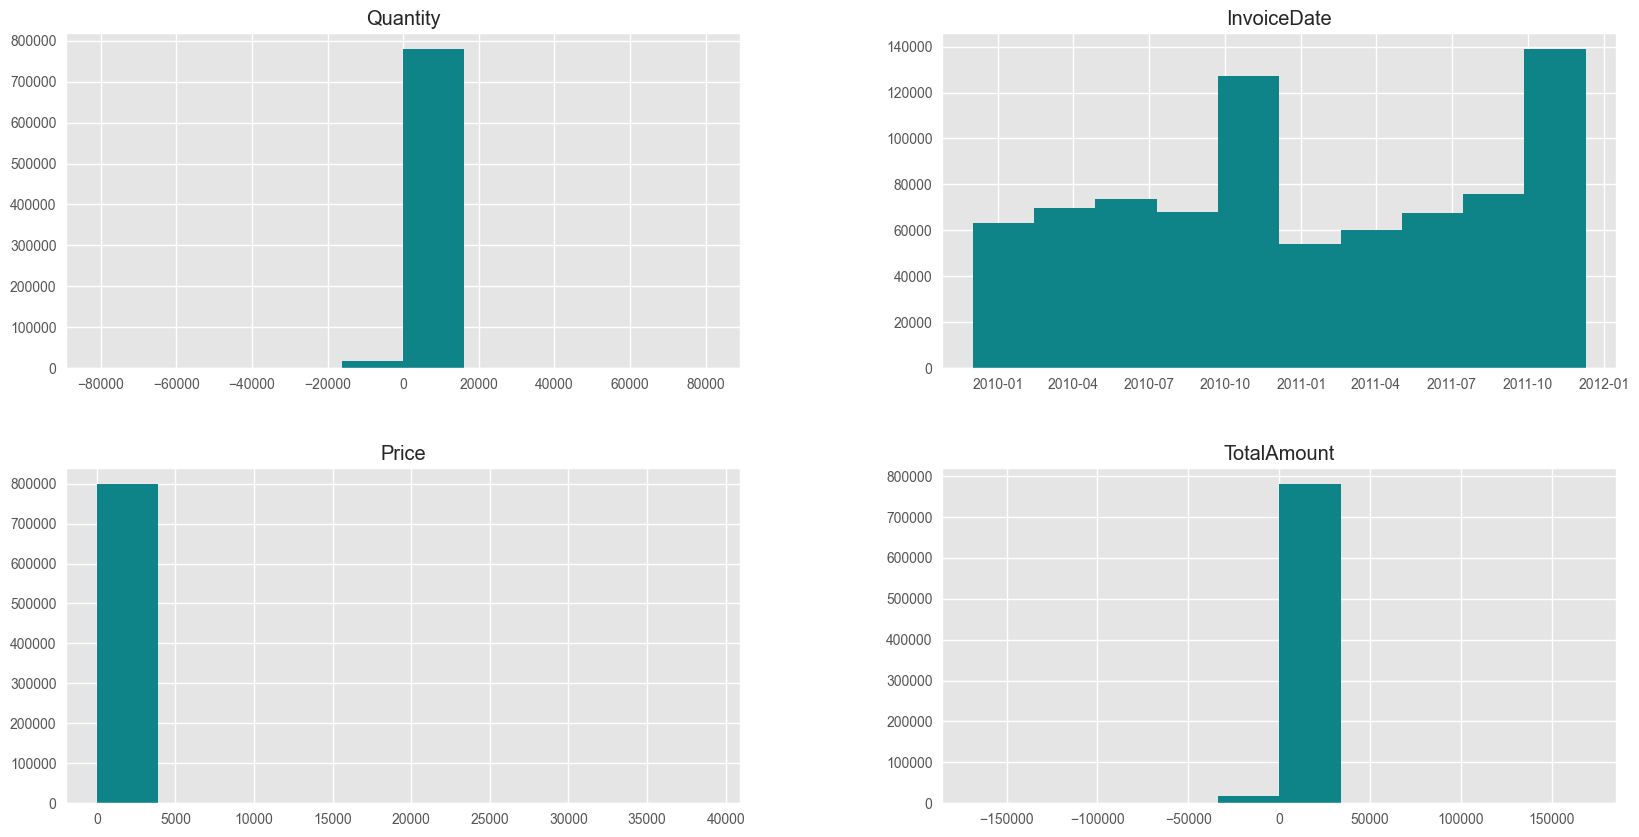

In [16]:
# To see the distribution of data
df[['Quantity','InvoiceDate','Price','TotalAmount']].hist(figsize=(20,10), color='#0E8388')
plt.show()

#### Observations
- Quantity and thus TotalAmount showing negative values.
- Price, Quantity and TotalAmount, are not normally distributed.
- From InvoiceDate, we can observe, some perticular days has high number of sales. We can use them to see which product are in demand for those days.

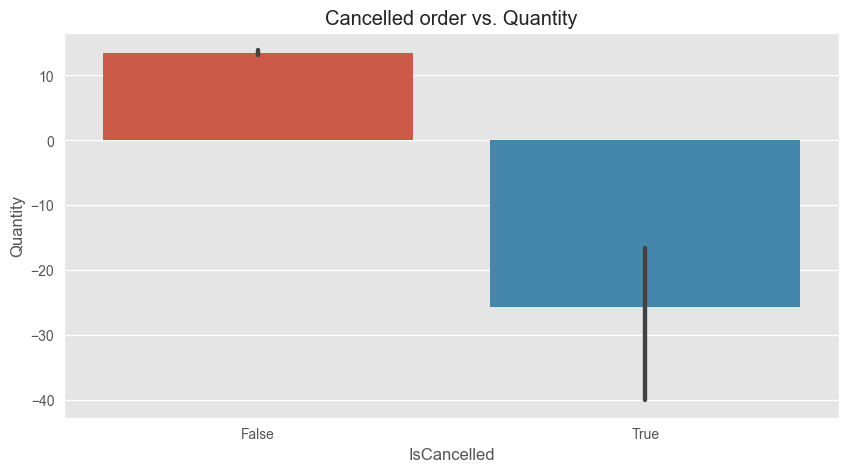

In [17]:
# Checking relationship between cancelled order and negative quantity
df['IsCancelled'] = False
df.loc[df['Invoice'].str.contains('C'),'IsCancelled'] = True
plt.figure(figsize=(10,5))
sns.barplot(x='IsCancelled', y='Quantity', data=df)
plt.title('Cancelled order vs. Quantity')
plt.show()

- It is clear that Cancelled order has quantity in negative.

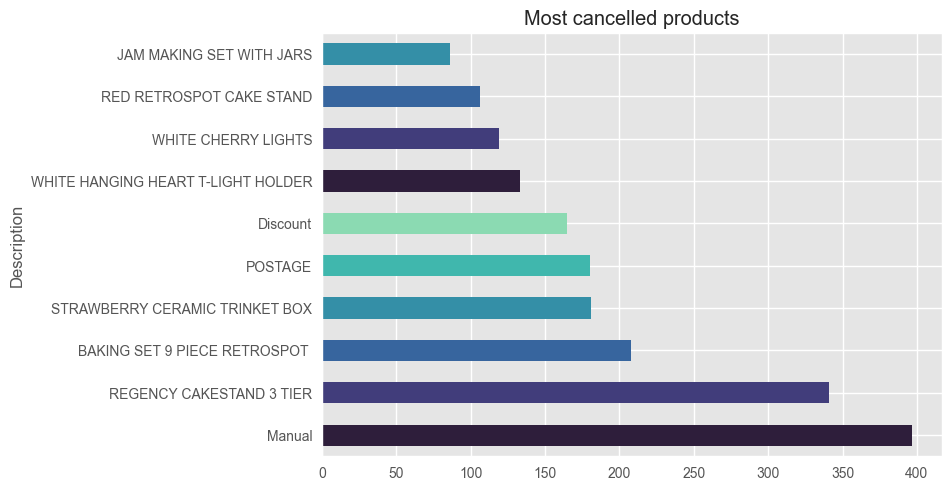

In [18]:
# Most cancelled products
df[df['Invoice'].str.upper().str.contains('C')]['Description'].value_counts()\
    .head(10).plot(kind='barh', title='Most cancelled products', color=sns.color_palette('mako'))
plt.show()

In [19]:
# Dropping cancelled products
df = df[~df.Invoice.str.startswith('C')]

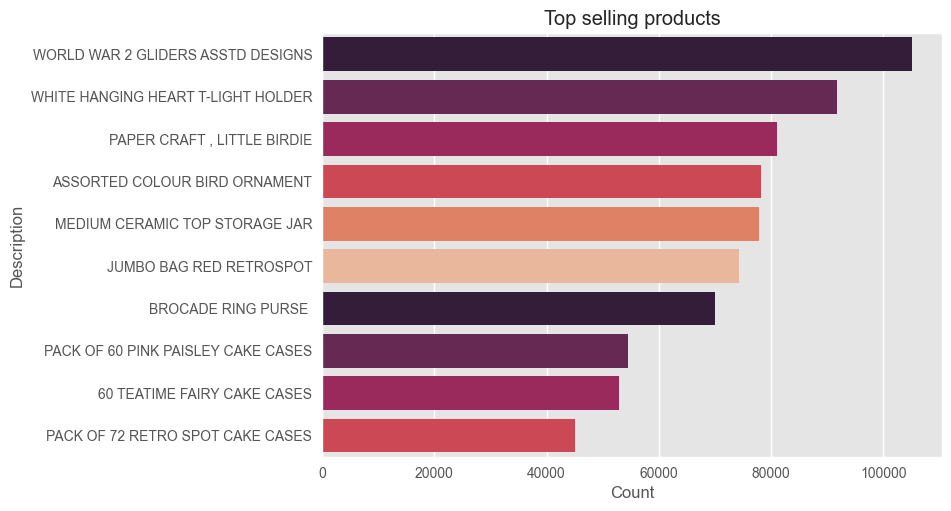

In [20]:
# Top selling products
top_selling_products = df.groupby(['Description'])['Quantity'].sum()\
    .sort_values(ascending=False).reset_index().head(10).rename(columns={'Quantity':'Count'})
sns.barplot(data=top_selling_products, x='Count', y='Description', palette=sns.color_palette('rocket'))
plt.title('Top selling products')
plt.show()

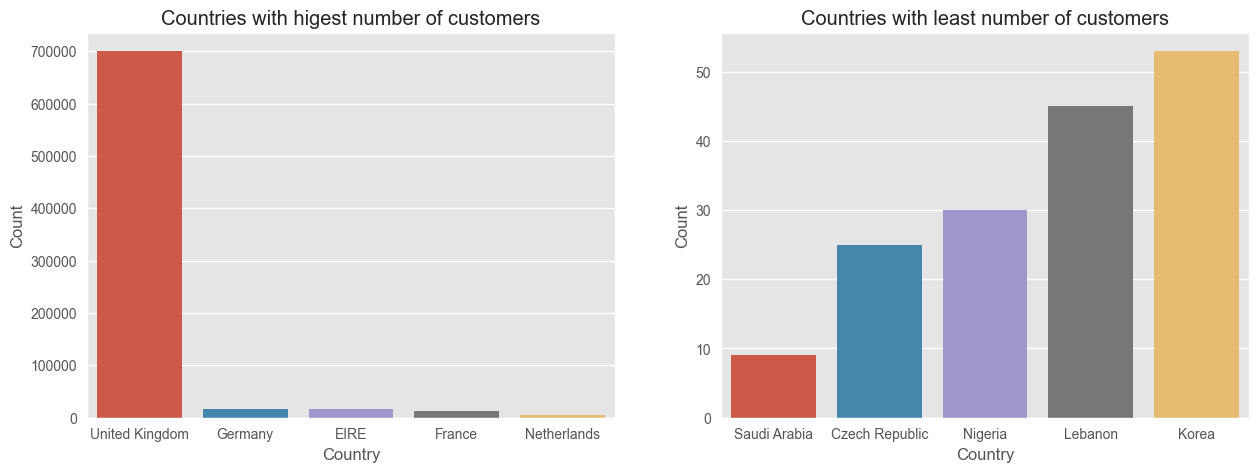

In [21]:
# Countries with higest number of customers and lowest number of customers
top_countries = df.groupby(['Country'])['CustomerID'].count().\
    sort_values(ascending=False).reset_index().head(5).rename(columns={'CustomerID':'Count'})

least_countries = df.groupby(['Country'])['CustomerID'].count().\
    sort_values().reset_index().head(5).rename(columns={'CustomerID':'Count'})

f, ax = plt.subplots(1,2, figsize=(15,5))
sns.barplot(x='Country', y='Count', data=top_countries, ax=ax[0])
ax[0].set_title('Countries with higest number of customers')

sns.barplot(x='Country', y='Count', data=least_countries, ax=ax[1])
ax[1].set_title('Countries with least number of customers')
plt.show()

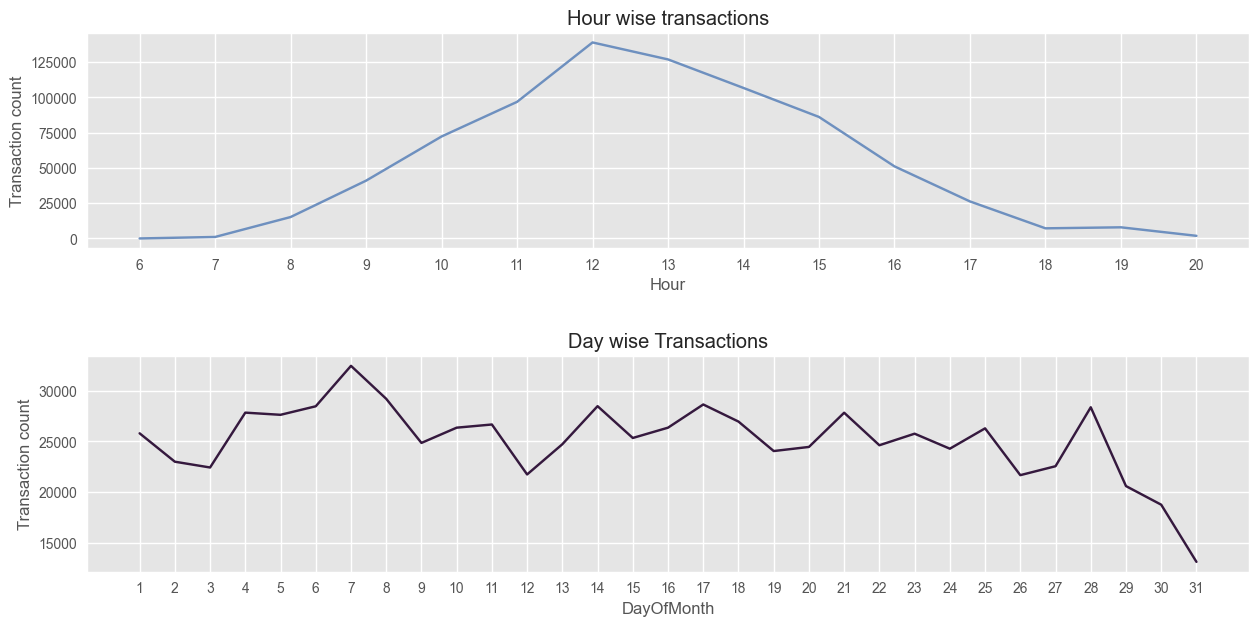

In [22]:
# Plotting hour and day wise transactions
f, ax = plt.subplots(2,1, figsize=(15,7))
plt.subplots_adjust(hspace=0.5)
df.groupby(['Hour'])['InvoiceDate'].count().plot(ax=ax[0], color=sns.color_palette('vlag'))
ax[0].set_xticks(df['Hour'].unique())
ax[0].set_ylabel('Transaction count')
ax[0].set_title('Hour wise transactions')

df.groupby(['DayOfMonth'])['InvoiceDate'].count().plot(ax=ax[1], color=sns.color_palette('rocket'))
ax[1].set_xticks(df['DayOfMonth'].unique())
ax[1].set_ylabel('Transaction count')
ax[1].set_title('Day wise Transactions')

plt.show()

#### Insights
- Sales are higest in between 11 AM and 3 PM.
- Lowest in the morning around 6 AM to 7 PM while at night around 6 PM to 8 PM.
- Sales are fluctuating all over the month's day but can see a peak as getting close to the 7th of every month, which could be due to salary credit in the first week.  

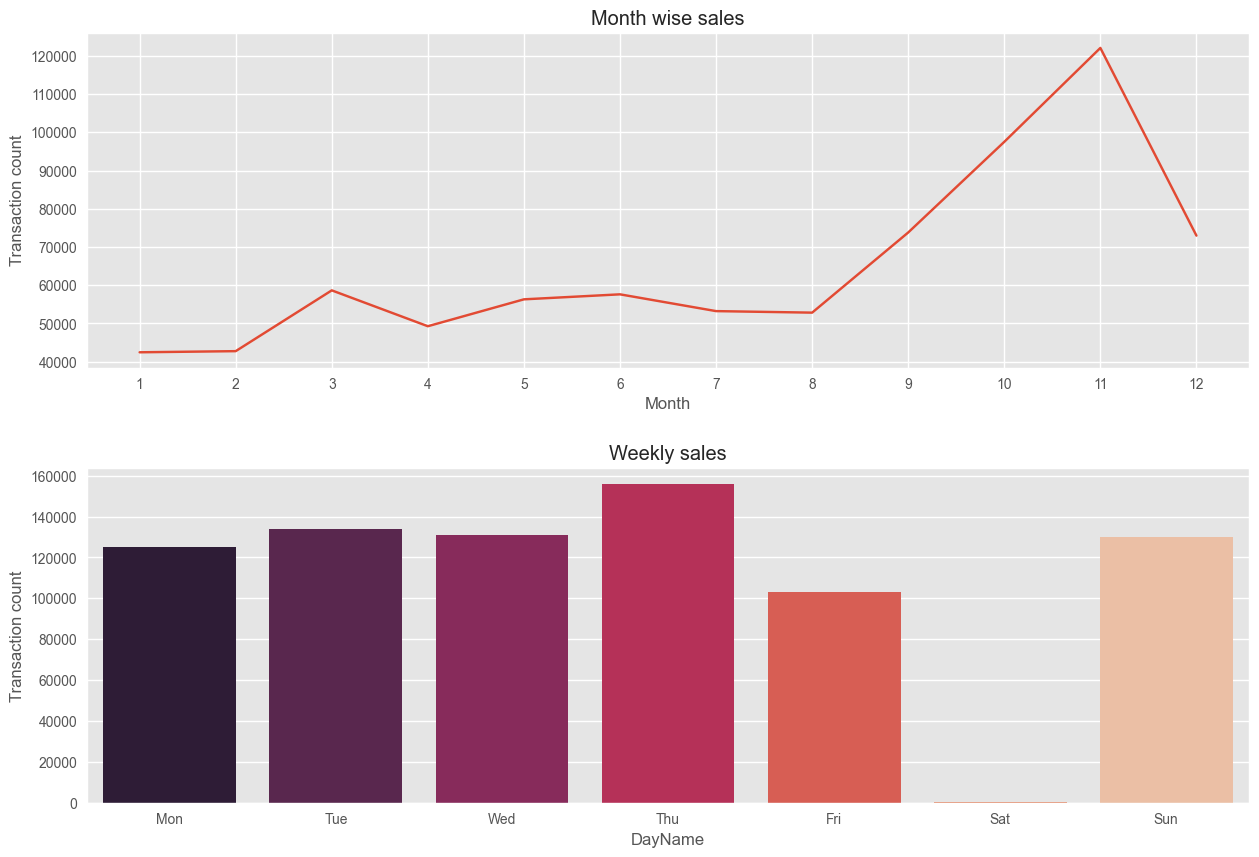

In [23]:
# Plotting month day and weekday wise sales
f, ax = plt.subplots(2,1, figsize=(15,10))
plt.subplots_adjust(hspace=0.3)
df.groupby(['Month'])['InvoiceDate'].count().plot(ax=ax[0])
ax[0].set_ylabel('Transaction count')
ax[0].set_xticks(df['Month'].unique())
ax[0].set_title('Month wise sales')

weekday_wise = df.groupby('DayOfWeek')['CustomerID'].count().reset_index()
day_names = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
weekday_wise['DayName'] = weekday_wise['DayOfWeek'].map(lambda x: day_names[x])
sns.barplot(x='DayName', y='CustomerID', data=weekday_wise, ax=ax[1], palette='rocket')
ax[1].set_ylabel('Transaction count')
ax[1].set_title('Weekly sales')

plt.show()

#### Insights
- Sales start rising after August, it may be due to festival season or holidays.
- Highest sales in the month of November, October, September and December.
- Lowest sales in the month of January and February.
- Sales are higest on Thurdays.
- Looks like, no order placed on Saturday, may be holiday for retailers.

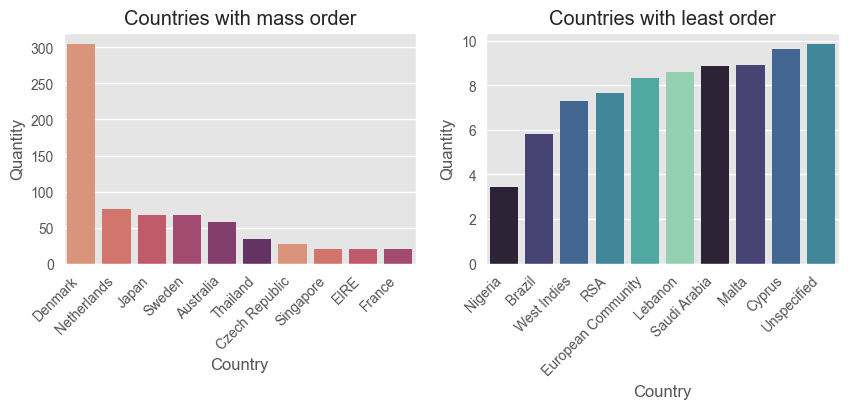

In [24]:
# Countries with mass order
countries_with_mass_order = df.groupby('Country')['Quantity'].mean().sort_values(ascending=False).reset_index().head(10)
countries_with_least_order = df.groupby('Country')['Quantity'].mean().sort_values().reset_index().head(10)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.barplot(data=countries_with_mass_order, x='Country', y='Quantity', palette=sns.color_palette('flare'))
plt.xticks(rotation=45, ha='right')
plt.title('Countries with mass order')

plt.subplot(1,2,2)
sns.barplot(data=countries_with_least_order, x='Country', y='Quantity', palette=sns.color_palette('mako'))
plt.xticks(rotation=45, ha='right')
plt.title('Countries with least order')

plt.show()

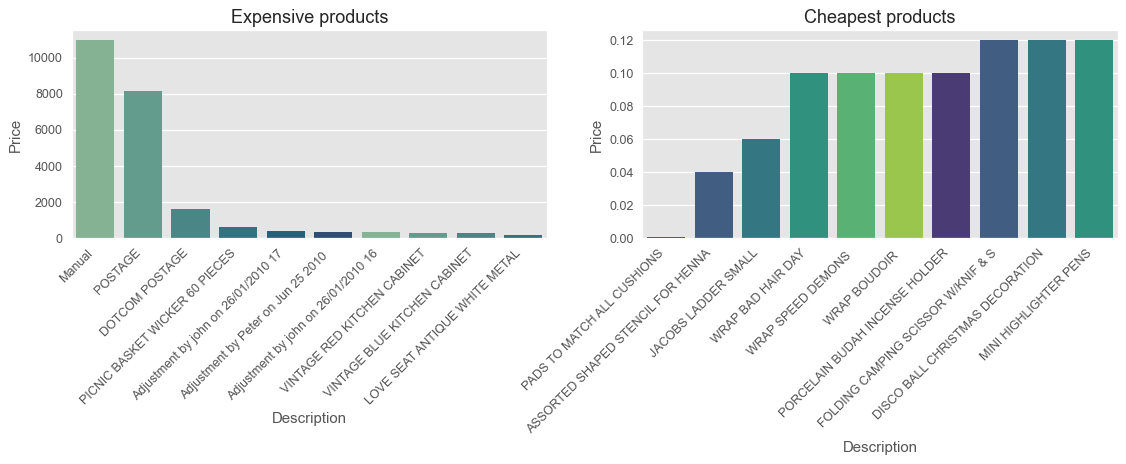

In [25]:
# Plotting expensive and cheapest products which are sold
expensive_products = df.groupby(['Description'])['Price'].max().sort_values(ascending=False).reset_index().head(10)
cheapest_products = df.groupby(['Description'])['Price'].max().sort_values().reset_index().head(10)

plt.figure(figsize=(15,3), dpi=90)
plt.subplot(1,2,1)
sns.barplot(x='Description', y='Price', data=expensive_products, palette=sns.color_palette('crest'))
plt.title('Expensive products')
plt.xticks(rotation=45, ha='right')

plt.subplot(1,2,2)
sns.barplot(x='Description', y='Price', data=cheapest_products, palette=sns.color_palette('viridis'))
plt.title('Cheapest products')
plt.xticks(rotation=45, ha='right')

plt.show()

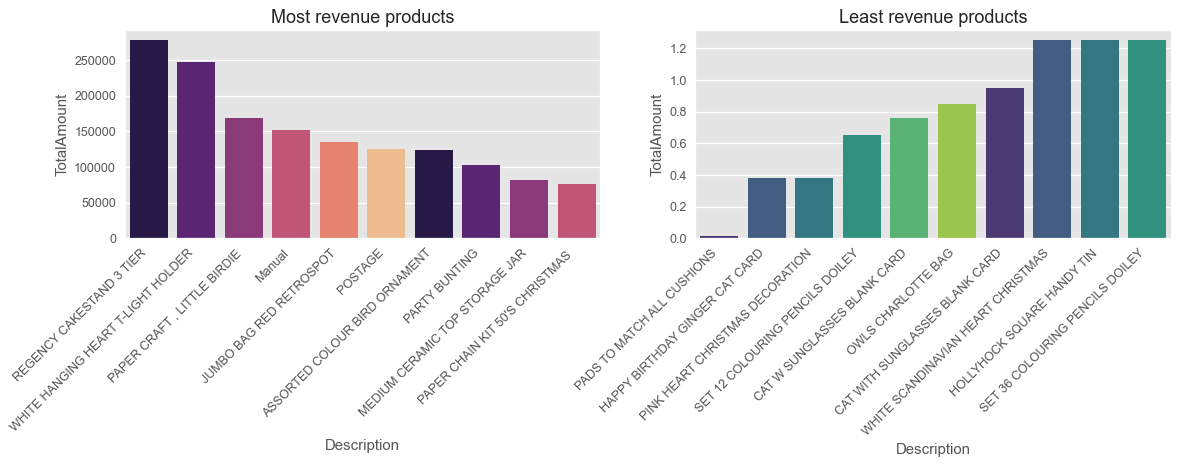

In [26]:
# Most revenue generating products and least reveneu generating products
most_revenue_products = df.groupby(['Description'])['TotalAmount'].sum().sort_values(ascending=False).reset_index().head(10)
least_revenue_products = df.groupby(['Description'])['TotalAmount'].sum().sort_values().reset_index().head(10)

plt.figure(figsize=(15,3), dpi=90)
plt.subplot(1,2,1)
sns.barplot(x='Description', y='TotalAmount', data=most_revenue_products, palette=sns.color_palette('magma'))
plt.title('Most revenue products')
plt.xticks(rotation=45, ha='right')

plt.subplot(1,2,2)
sns.barplot(x='Description', y='TotalAmount', data=least_revenue_products, palette=sns.color_palette('viridis'))
plt.title('Least revenue products')
plt.xticks(rotation=45, ha='right')

plt.show()

## RFM modelling
-  RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns.

In [27]:
# Recency
recent_date = df.InvoiceDate.max() + timedelta(days=1)
r_df = df.groupby('CustomerID')['InvoiceDate']\
    .agg(lambda group: (recent_date - group.max()).days).reset_index().rename(columns={'InvoiceDate':'Recency'})
r_df.head(2)

,CustomerID,Recency
0,12346.0,326
1,12347.0,2


In [28]:
# Frequency
f_df = df.groupby('CustomerID')['Invoice'].count().reset_index().rename(columns={'Invoice':'Frequency'})
f_df.head(2)

,CustomerID,Frequency
0,12346.0,34
1,12347.0,222


In [29]:
# Dropping cancelled orders
df = df[df.IsCancelled==False]

In [30]:
# Monetary
m_df = df.groupby('CustomerID')['TotalAmount'].sum().reset_index().rename(columns={'TotalAmount':'Monetary'})
m_df.head(2)

,CustomerID,Monetary
0,12346.0,77556.46
1,12347.0,4921.53


In [31]:
# RFM dataframe merging
rfm_df = pd.merge(r_df, f_df, on='CustomerID').merge(m_df, on='CustomerID')

In [32]:
# Creating RFM_Score based on the RFM values
rfm_df['R'] = pd.qcut(rfm_df.Recency, q=4, labels=[4,3,2,1]).astype(int)
rfm_df['F'] = pd.qcut(rfm_df.Frequency, q=4, labels=[1,2,3,4]).astype(int)
rfm_df['M'] = pd.qcut(rfm_df.Monetary, q=4, labels=[1,2,3,4]).astype(int)
rfm_df['RFM'] = rfm_df.R*100 + rfm_df.F*10 + rfm_df.M
rfm_df['RFM_Score'] = rfm_df.R + rfm_df.F + rfm_df.M
rfm_df.head(2)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM,RFM_Score
0,12346.0,326,34,77556.46,2,2,4,224,8
1,12347.0,2,222,4921.53,4,4,4,444,12


##### Interpretation
- RFM explains which type of customer is it. 
- If RFM is 444 that means he/she has very good Recency, Frequency and Monetary. Best customer.
- If RFM is 414, the customer has recently bought something and has very good Monetary but frequency is poor.
- If RFM is 111 that means poor in all three. Churning customer.
- Like wise, RFM_Score tells the overall score of the customer, the higher the score, better the customer.

In [33]:
# Getting descriptive statistics
rfm_df.describe()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM,RFM_Score
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,15314.674205,201.457745,132.544635,2954.396237,2.510797,2.493794,2.499745,278.517429,7.504336
std,1715.429759,209.474135,342.153047,14437.322635,1.122858,1.118188,1.118205,118.522361,2.844739
min,12346.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,111.000000,3.000000
25%,13833.000000,26.000000,20.000000,341.900000,2.000000,1.000000,1.000000,211.000000,5.000000
50%,15313.000000,96.000000,52.000000,865.600000,3.000000,2.000000,2.000000,311.000000,7.000000
75%,16797.000000,380.000000,138.000000,2247.720000,4.000000,3.000000,3.000000,411.000000,10.000000
max,18287.000000,739.000000,12435.000000,580987.040000,4.000000,4.000000,4.000000,444.000000,12.000000


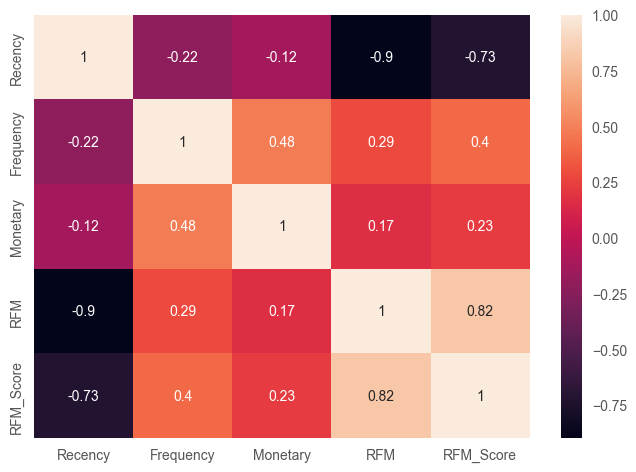

In [34]:
# Plotting correlation matrix 
corr_df = rfm_df[['Recency','Frequency','Monetary','RFM','RFM_Score']]
sns.heatmap(corr_df.corr(), annot=True)
plt.show()

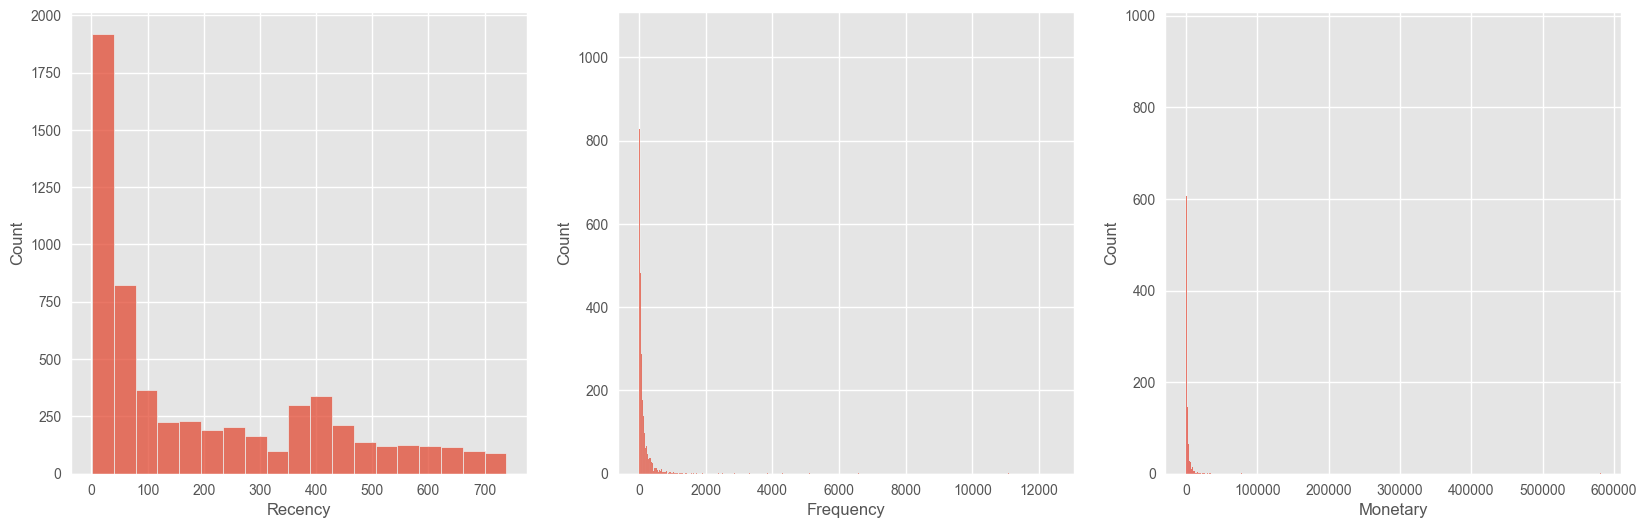

In [35]:
# Distribution of RFM
plt.figure(figsize=(20,6))
for i, col in enumerate(rfm_df[['Recency','Frequency','Monetary']]):
    plt.subplot(1,3, i+1)
    sns.histplot(rfm_df[col])
plt.show()

- Seems, data is not normally distributed. Can use some scalling method to make it bit normal.

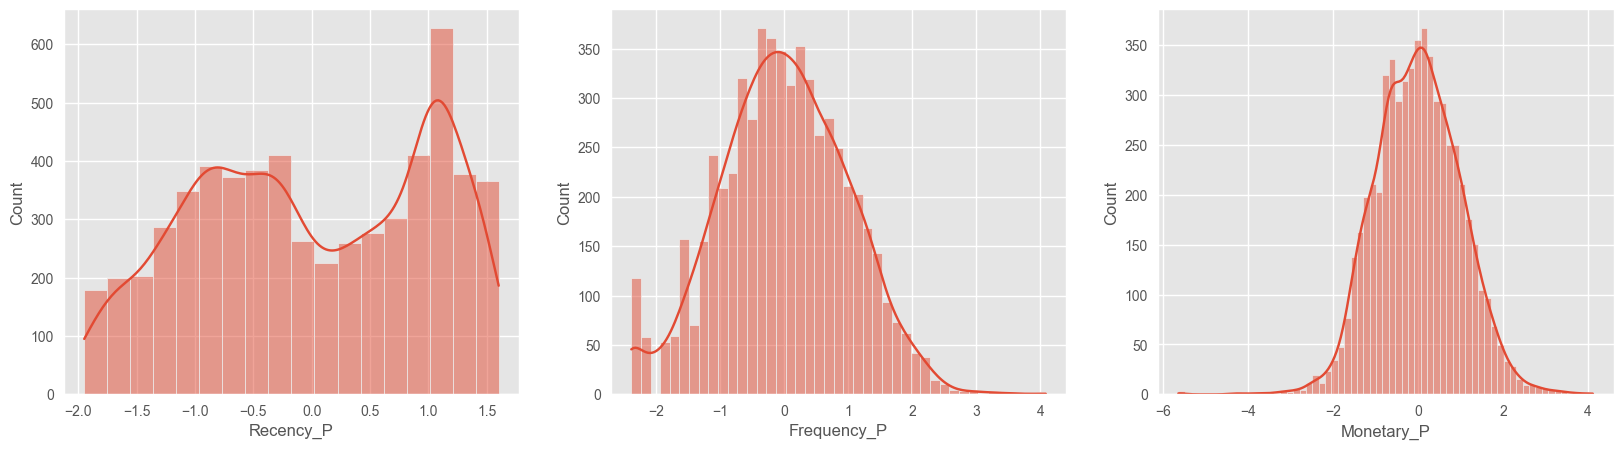

In [36]:
# Applying powertransformer
pt = PowerTransformer()
rfm_df[['Recency_P','Frequency_P','Monetary_P']] = pd.DataFrame(pt.fit_transform(rfm_df[['Recency','Frequency','Monetary']]))
f, ax = plt.subplots(1,3, figsize=(20,5))
sns.histplot(x='Recency_P', data=rfm_df, ax=ax[0], kde=True)
sns.histplot(x='Frequency_P', data=rfm_df, ax=ax[1], kde=True)
sns.histplot(x='Monetary_P', data=rfm_df, ax=ax[2], kde=True)
plt.show()

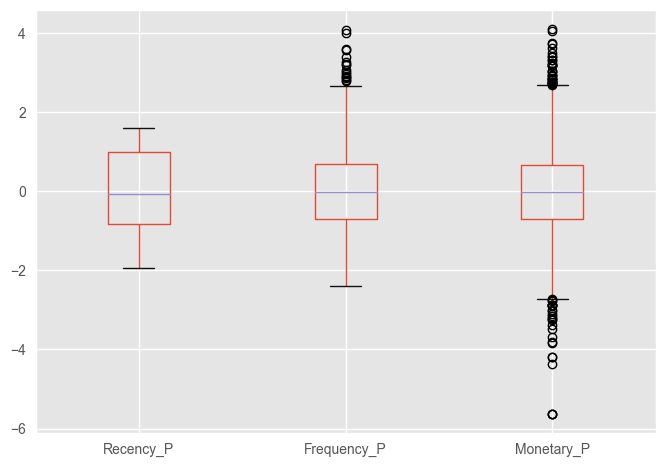

In [37]:
# Looking for outliers
rfm_df[['Recency_P','Frequency_P','Monetary_P']].boxplot()
plt.show()

##### Observation
- Frequency and Monetary showing presence of outliers

In [38]:
def handle_outlier(df, cols):
    """
    Fixing outlier and imputing with capping.
    """
    X_new = df.copy()
    for col in cols:
        percentile25, percentile75 = X_new[col].quantile(0.25), X_new[col].quantile(0.75)
        iqr = percentile75 - percentile25
        lower_limit = percentile25 - 1.5 * iqr
        upper_limit = percentile75 + 1.5 * iqr
        lower_limit, upper_limit

        X_new[col] = np.where(X_new[col] > upper_limit, upper_limit, \
                                       np.where(X_new[col] < lower_limit, lower_limit, X_new[col]))
    return X_new

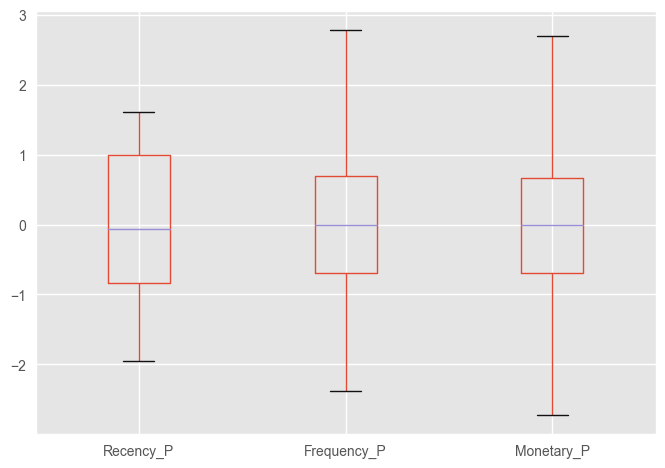

In [39]:
# Presence of outliers after fixing
cols = ['Recency_P','Frequency_P','Monetary_P']
rfm_df = handle_outlier(rfm_df, cols)
rfm_df[['Recency_P','Frequency_P','Monetary_P']].boxplot()
plt.show()

## Clustering

In [40]:
# Clusters based on quantile binning
y = pd.qcut(rfm_df['RFM_Score'], q=4, labels=[1,2,3,4]).astype(int)
rfm_df['BinningClusters'] = y

In [41]:
# Applying KMeans clustering algorithm to cluster the customers
X = rfm_df[['Recency_P','Frequency_P','Monetary_P']]
kmeans = KMeans()
y = kmeans.fit_predict(X)

d:\DSProjects\Segmentation\RetailCustomerSegmentation\RetailCustomerSegmentation\venvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [42]:
# Displaying clusters based on default values
fig = px.scatter_3d(data_frame=X, x='Recency_P', y='Frequency_P', z='Monetary_P', color=y)
fig.show()

In [43]:
# Getting value of K using elbow method and silhouette method
k = list(range(2,7))
ssd = []
score = []
for n in k:
    cluster = KMeans(n_clusters=n)
    y = cluster.fit_predict(X)
    ssd.append(cluster.inertia_)
    score.append(silhouette_score(X, y))

d:\DSProjects\Segmentation\RetailCustomerSegmentation\RetailCustomerSegmentation\venvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

d:\DSProjects\Segmentation\RetailCustomerSegmentation\RetailCustomerSegmentation\venvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

d:\DSProjects\Segmentation\RetailCustomerSegmentation\RetailCustomerSegmentation\venvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

d:\DSProjects\Segmentation\RetailCustomerSegmentation\RetailCustomerSegmentation\venvironment\Lib\site-packages\sklearn\cluster

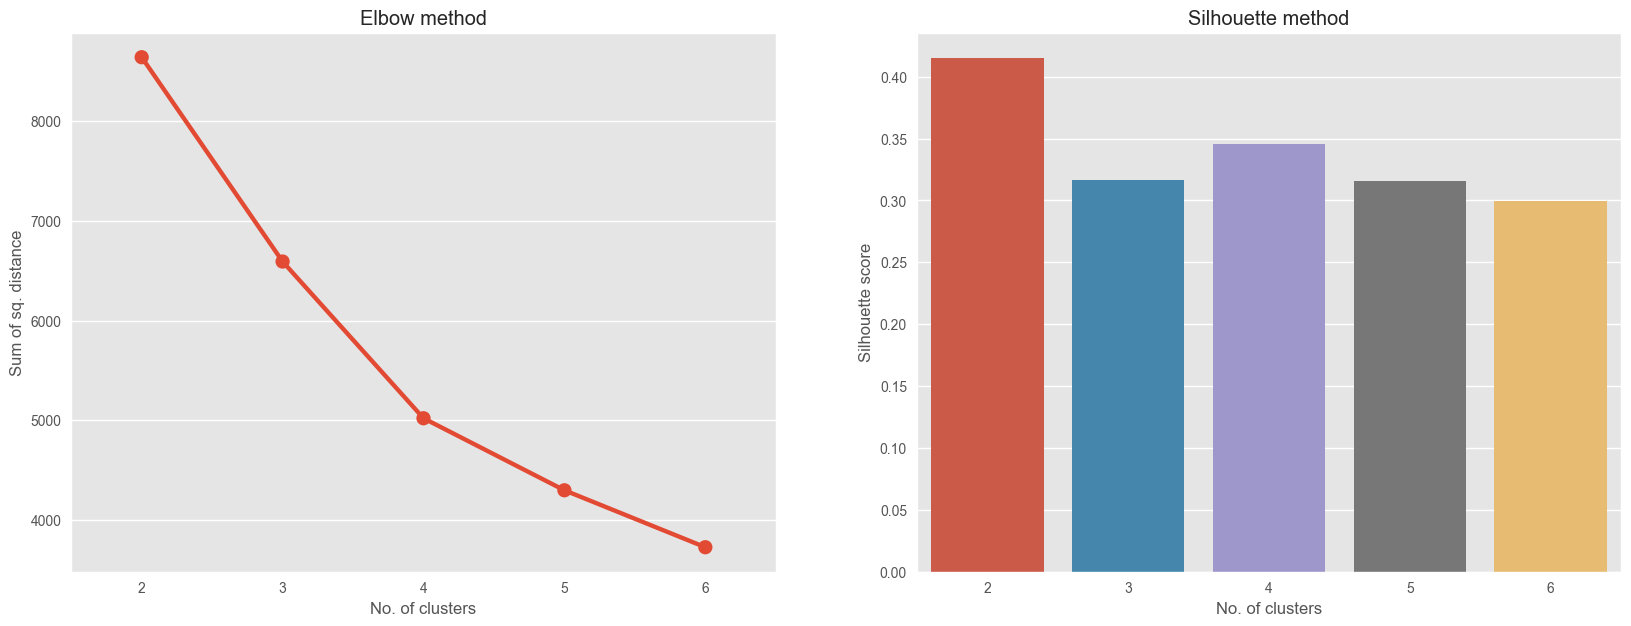

In [44]:
# Plotting graphs for elbow and silhouette method.
f, ax = plt.subplots(1,2, figsize=(20,7))
sns.pointplot(x=k, y=ssd, ax=ax[0])
ax[0].set_title('Elbow method')
ax[0].set_xlabel('No. of clusters')
ax[0].set_ylabel('Sum of sq. distance')

sns.barplot(x=k, y=score, ax=ax[1])
ax[1].set_title('Silhouette method')
ax[1].set_xlabel('No. of clusters')
ax[1].set_ylabel('Silhouette score')
plt.show()

#### Observation
- By elbow method, 4 seems to be the right number of clusters.
- By silhouette method, 2 and 4 seems the right number of clusters.
- Hence, we can go with 4 as 2 would be very less number of clusters.

In [45]:
# Plotting clusters based on elbow method
km = KMeans(n_clusters=4)
y = km.fit_predict(X)
rfm_df['KMeansElbow'] = y
px.scatter_3d(data_frame=X, x='Recency_P', y='Frequency_P', z='Monetary_P', color=y)

d:\DSProjects\Segmentation\RetailCustomerSegmentation\RetailCustomerSegmentation\venvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



d:\DSProjects\Segmentation\RetailCustomerSegmentation\RetailCustomerSegmentation\venvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



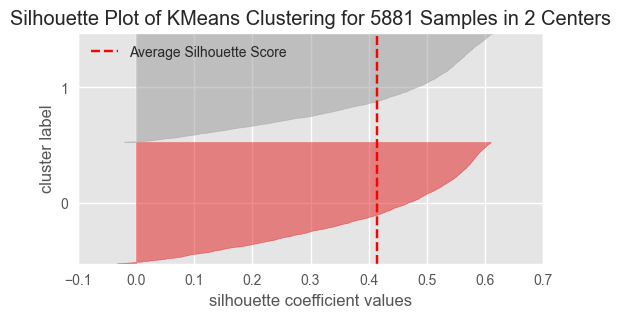

d:\DSProjects\Segmentation\RetailCustomerSegmentation\RetailCustomerSegmentation\venvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



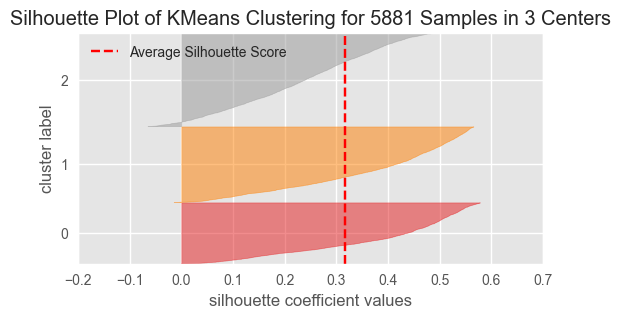

d:\DSProjects\Segmentation\RetailCustomerSegmentation\RetailCustomerSegmentation\venvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



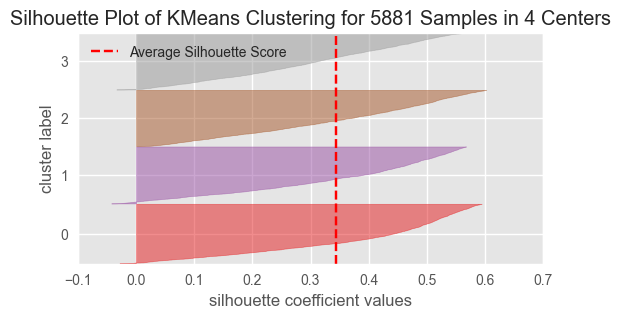

d:\DSProjects\Segmentation\RetailCustomerSegmentation\RetailCustomerSegmentation\venvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



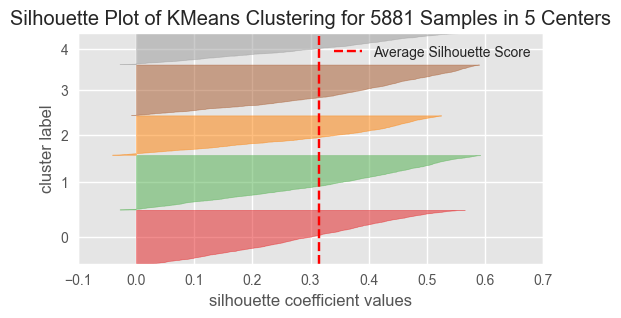

d:\DSProjects\Segmentation\RetailCustomerSegmentation\RetailCustomerSegmentation\venvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



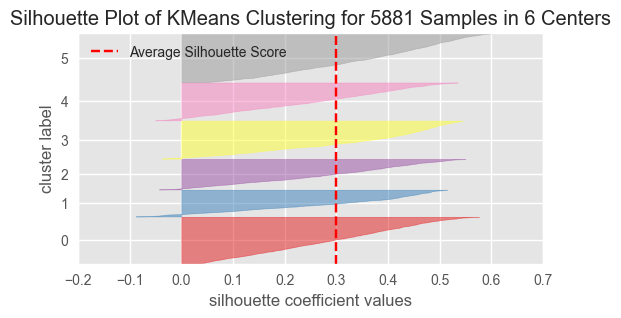

In [46]:
# Plotting Silhouette score based clusters 
for i in k:
    plt.figure(figsize=(6,3))
    cluster = KMeans(i)
    sv = SilhouetteVisualizer(estimator=cluster)
    sv.fit(X)
    sv.show()

In [47]:
# Plotting clusters based on silhouette method
km = KMeans(n_clusters=2)
y = km.fit_predict(X)
rfm_df['KMeansSilhouette'] = y
px.scatter_3d(data_frame=X, x='Recency_P', y='Frequency_P', z='Monetary_P', color=y)

d:\DSProjects\Segmentation\RetailCustomerSegmentation\RetailCustomerSegmentation\venvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [48]:
# Clustering using quantile binning
def get_insights(data, cluster_technique):
    """
    To get the cluster plot and insights of created clusters 
    """
    df = data.copy()
    f, ax = plt.subplots(3,1, figsize=(10,10))
    cols = ['Recency','Frequency','Monetary']
    df = handle_outlier(df, cols)
    sns.histplot(data=df, x='Recency', hue=rfm_df[cluster_technique], ax=ax[0], element='poly')
    sns.histplot(data=df, x='Frequency', hue=rfm_df[cluster_technique], ax=ax[1], element='poly')
    sns.histplot(data=df, x='Monetary', hue=rfm_df[cluster_technique], ax=ax[2], element='poly')
    plt.show()

    clusters = df.groupby(cluster_technique)\
        .agg({'Recency':lambda rec: f'{rec.quantile(0.25)} to {rec.quantile(0.75)} days ago', \
              'Frequency':lambda fre: f'{fre.quantile(0.25)} to {fre.quantile(0.75)} times',\
              'Monetary':lambda mon: f'{mon.quantile(0.25):.2f} to {mon.quantile(0.75):.2f} spends'}).reset_index()
    clusters.columns = [cluster_technique, 'Last Puchase','Purchase frequency', 'Amount spend']
    display(clusters)

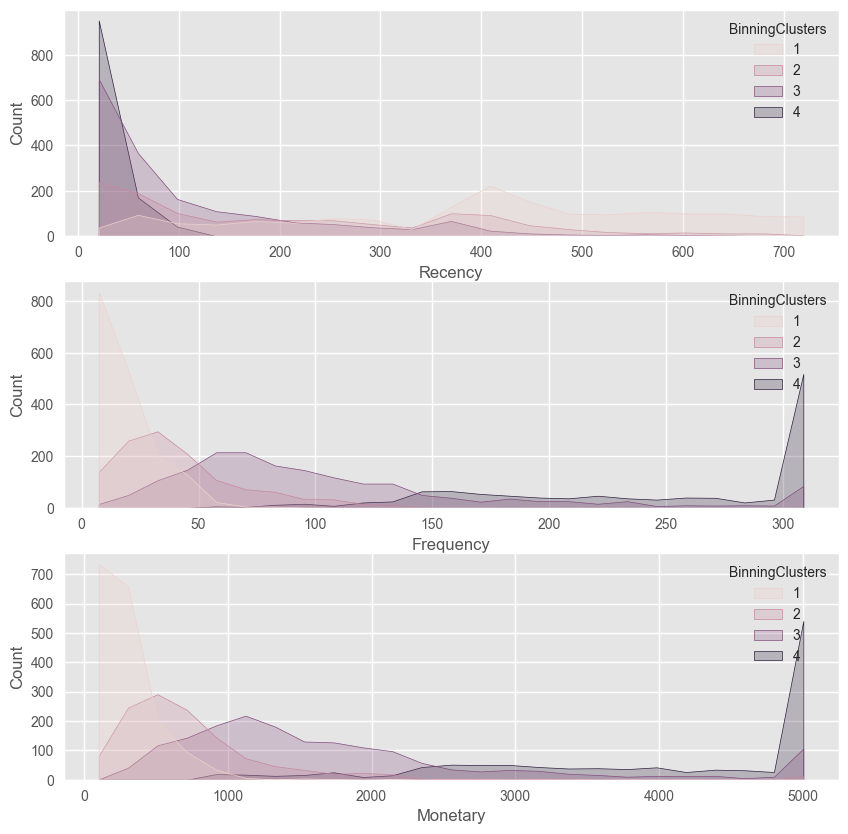

,BinningClusters,Last Puchase,Purchase frequency,Amount spend
0,1,266.5 to 563.0 days ago,7.0 to 23.0 times,141.44 to 359.38 spends
1,2,54.0 to 373.0 days ago,23.0 to 54.0 times,397.64 to 915.94 spends
2,3,22.0 to 145.75 days ago,58.0 to 130.0 times,975.22 to 2143.85 spends
3,4,5.0 to 30.0 days ago,180.0 to 315.0 times,2989.22 to 5106.45 spends


In [49]:
# Cluster view and insights of Quantile based clusters 
method = 'BinningClusters'
get_insights(rfm_df, method)

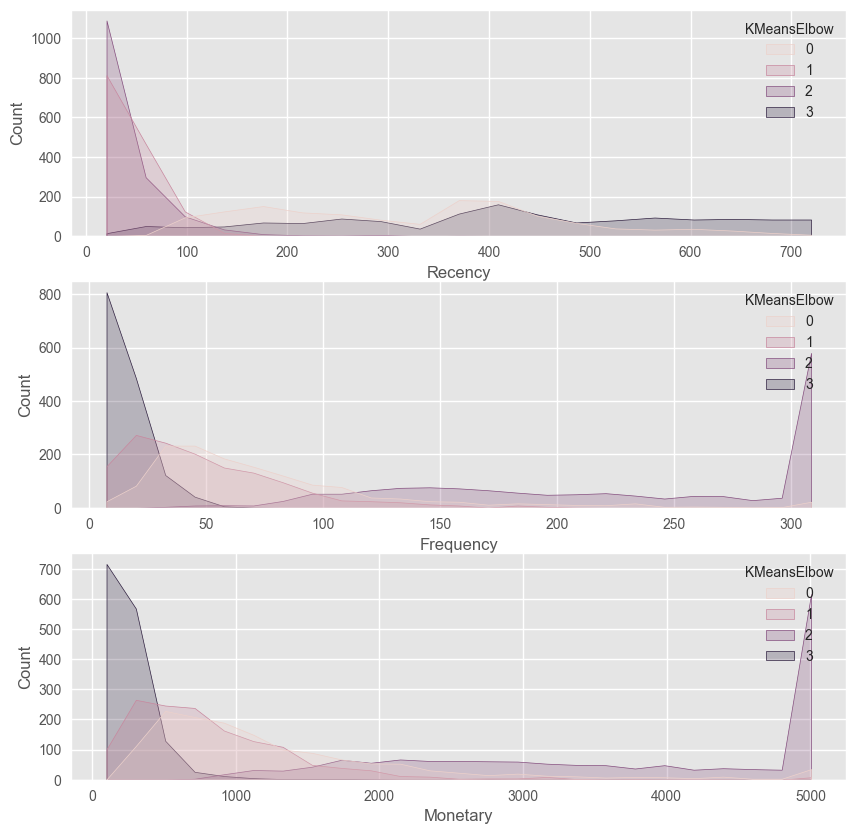

,KMeansElbow,Last Puchase,Purchase frequency,Amount spend
0,0,190.0 to 421.5 days ago,39.5 to 95.0 times,623.37 to 1662.63 spends
1,1,17.0 to 60.0 days ago,23.0 to 67.0 times,397.93 to 1096.93 spends
2,2,8.0 to 46.75 days ago,152.25 to 315.0 times,2485.44 to 5106.45 spends
3,3,266.0 to 576.0 days ago,6.0 to 20.0 times,130.60 to 323.58 spends


In [50]:
# Cluster view and insights of KMeans Elbow based clusters 
method = 'KMeansElbow'
get_insights(rfm_df, method)

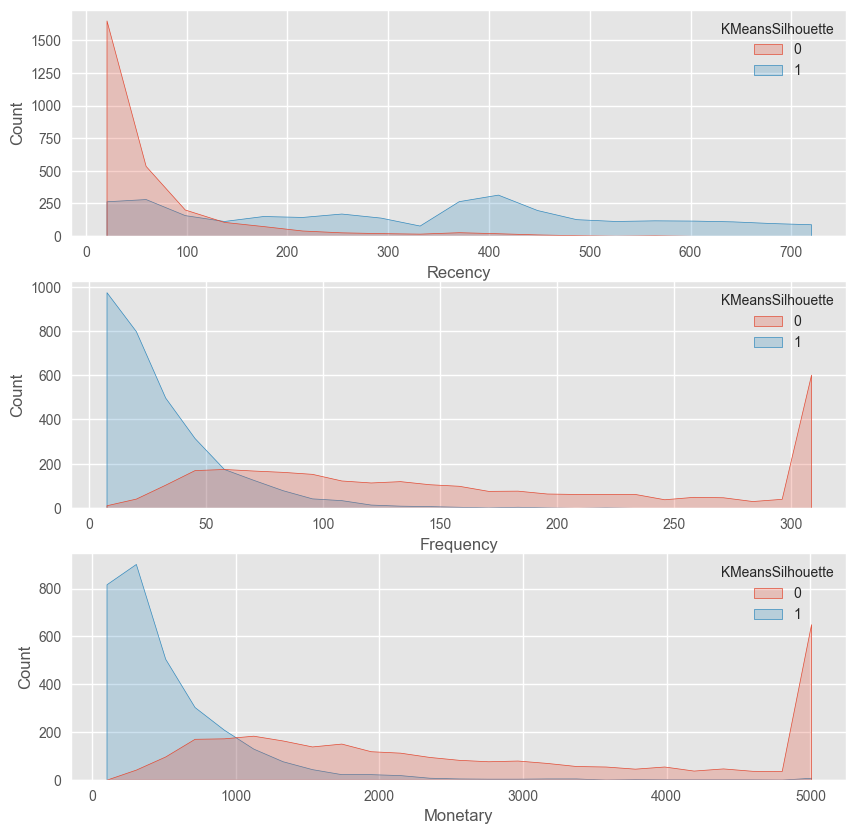

,KMeansSilhouette,Last Puchase,Purchase frequency,Amount spend
0,0,11.0 to 69.0 days ago,78.0 to 272.25 times,1260.44 to 4641.86 spends
1,1,138.0 to 471.0 days ago,11.0 to 40.0 times,195.36 to 665.78 spends


In [51]:
# Cluster view and insights of KMeans Silhouette based clusters 
method = 'KMeansSilhouette'
get_insights(rfm_df, method)

## Conclusion:
- Retail organization can use the clusters to target perticular customers based on their Recency which is last purchase days, frequency which is times the buyer buys the goods and Monetary ie., money spend by the customer.